# Chapter 6 Statistical Machine Learning
### Imported libraries

In [38]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree, textDecisionTree
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBClassifier
from itertools import product

### K-Nearest Neighbors

In [2]:
loan200 = pd.read_csv('loan200.csv')

In [3]:
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'

newloan = loan200.loc[0:0,predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)

array(['paid off'], dtype=object)

In [4]:
loan_data = pd.read_csv('loan_data.csv')

In [5]:
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0,predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
X.iloc[nbrs[1][0], :]

,payment_inc_ratio,dti,revol_bal,revol_util
35536,1.47212,1.46,1686,10.0
33651,3.38178,6.37,1688,8.4
25863,2.36303,1.39,1691,3.5
42953,1.28160,7.14,1684,3.9
43599,4.12244,8.98,1684,7.2


In [6]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
X.iloc[nbrs[1][0], :]

,payment_inc_ratio,dti,revol_bal,revol_util
2080,2.61091,1.03,1218,9.7
1438,2.34343,0.51,278,9.9
30215,2.71200,1.34,1075,8.5
28542,2.39760,0.74,2917,7.4
44737,2.34309,1.37,488,7.2


### KNN as a Feature Engine

In [7]:
predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)

loan_data['borrower_score'] = knn.predict_proba(X)[:, 1]
loan_data['borrower_score'].describe()

count    45342.000000
mean         0.498909
std          0.128728
min          0.050000
25%          0.400000
50%          0.500000
75%          0.600000
max          1.000000
Name: borrower_score, dtype: float64

### A Simple Example

In [8]:
loan3000 = pd.read_csv('loan3000.csv')

In [12]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', min_impurity_decrease=0.003)
loan_tree.fit(X, y)
#plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.003,
                       random_state=1)

In [13]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


### Random Forest

In [15]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, oob_score=True)
rf.fit(X, y)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1)

<AxesSubplot: xlabel='n'>

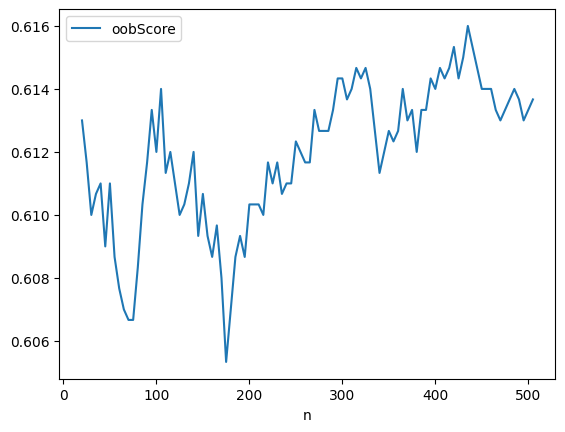

In [16]:
n_estimator = list(range(20, 510, 5))
oobScores= []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, criterion='entropy', max_depth=5, random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)
df = pd.DataFrame({'n':n_estimator, 'oobScore': oobScores})
df.plot(x='n', y='oobScore')

Text(0, 0.5, 'payment_inc_ratio')

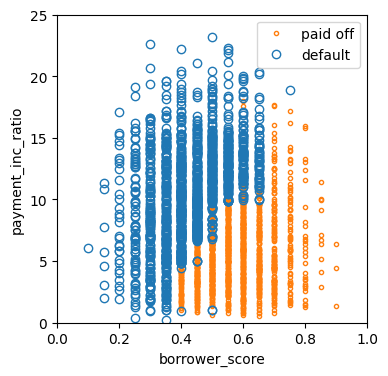

In [17]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4,4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction == 'default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor = 'C0', ax=ax)
ax.legend(['paid off', 'default'])
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

### Variable Importance

In [18]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 'payment_inc_ratio',
'revol_bal', 'revol_util', 'purpose', 'delinq_2yrs_zero',
'pub_rec_zero', 'open_acc', 'grade', 'emp_length', 'purpose_',
'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [19]:
importances = rf_all.feature_importances_

In [23]:
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)

# cross-validate the scores on a number of differnet random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)

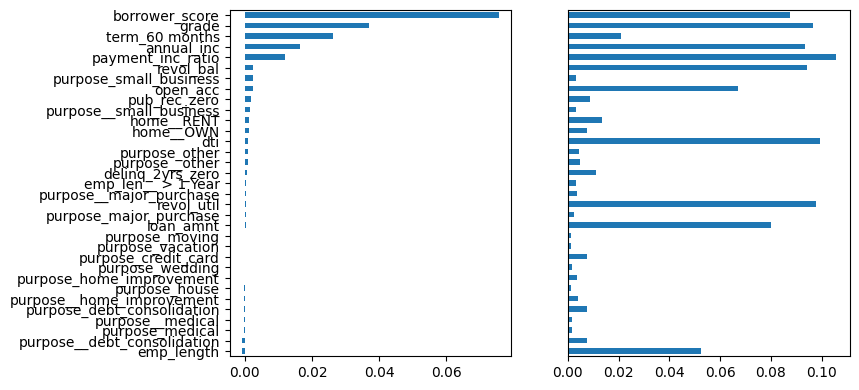

In [24]:
df = pd.DataFrame({
    'feature': X.columns,
    'Accuracy decrease': [np.mean(scores[column]) for column in X.columns],
    'Gini decrease': rf_all.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 4.5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease',
             legend= False, ax=axes[0])
ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease',
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

### XGBoost

In [28]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])

xgb = XGBClassifier(objective='binary:logistic', subsample=0.63)
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
n_estimators=100, n_jobs=1, nthread=None, objective='binary:logistic',
random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
silent=None, subsample=0.63, verbosity=1)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=3, max_leaves=None, min_child_weight=1, missing=None,
              monotone_constraints=None, n_estimators=100, n_jobs=1,
              nthread=None, num_parallel_tree=None, predictor=None, ...)

In [29]:
xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]

Text(0, 0.5, 'payment_inc_ratio')

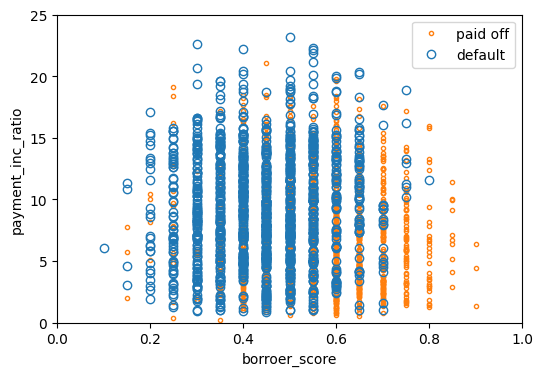

In [31]:
fig, ax = plt.subplots(figsize=(6,4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default'])
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borroer_score')
ax.set_ylabel('payment_inc_ratio')

### Regularization: Avoiding Overfitting

In [33]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 'payment_inc_ratio',
'revol_bal', 'revol_util', 'purpose', 'delinq_2yrs_zero',
'pub_rec_zero', 'open_acc', 'grade', 'emp_length', 'purpose_',
'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250,
                            max_depth=6, reg_lambda=0, learning_rate=0.3,
                            subsample=1)
xgb_default.fit(train_X, train_y)
pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

default:  0.36


In [34]:
xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250,
                            max_depth=6, reg_lambda=1000, learning_rate=0.1,
                            subsample=0.63)
xgb_penalty.fit(train_X, train_y)
pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

penalty:  0.3355


In [35]:
results = []
for i in range(1, 250):
    train_default = xgb_default.predict_proba(train_X, ntree_limit=i)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, ntree_limit=i)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, ntree_limit=i)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, ntree_limit=i)[:, 1]
    results.append({
        'iterations':i,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

c:\Users\Vikas Chauhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [36]:
results = pd.DataFrame(results)
results.head()

,iterations,default train,penalty train,default test,penalty test
0,1,0.339483,0.336342,0.3508,0.3548
1,2,0.330457,0.334842,0.3487,0.3470
2,3,0.326580,0.337757,0.3431,0.3500
3,4,0.323864,0.337474,0.3415,0.3488
4,5,0.320752,0.338323,0.3422,0.3488


<AxesSubplot: xlabel='iterations'>

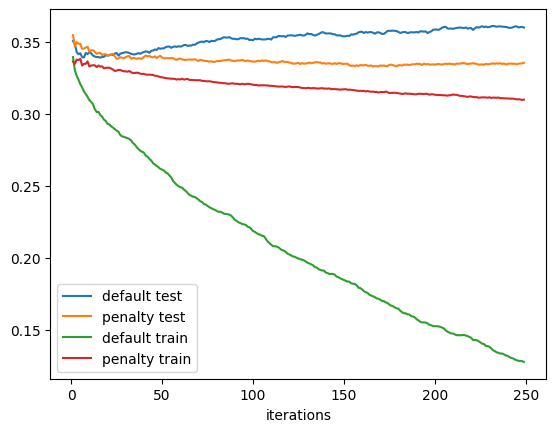

In [37]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)

### Hyperparameters and Cross-Validation

In [39]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators= 250,
                        max_depth=max_depth, learning_rate=eta)
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.32791671876372436}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.3347624767534695}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.347060002614059}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.3402664958129191}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.3690895522695033}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.37490846635071556}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.3550760887656937}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.3863604110095581}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.3840589736271866}
